In [3]:
import os
import random
import shutil, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pylab as pl
from matplotlib.pyplot import figure
from collections import Counter

from os import listdir
from os.path import isfile, join

In [142]:
truth_file = pd.read_csv('/Users/sleung2/Documents/MIDS Program/Capstone_local/snapshot_wisconsin/all/yolo_splits3/test/test_labels.csv')
truth_file = truth_file.rename(columns = {'TRIGGER_ID': 'event_id',
                                               'CLASS_SPECIES': 'true_class',
                                               'Total': 'true_count',
                                               'CLASS_SPECIES_RESTATED': 'true_class_name'})

truth_file_no_other = truth_file[truth_file['true_class_name'] != 'other']

In [6]:
labels = pd.DataFrame(['foxgray_foxred',
              'cottontail_snowshoehare',
              'raccoon',
              'opossum',
              'turkey',
              'bear',
              'elk',
              'deer',
              'coyote',
              'wolf']).sort_values(0)
labels = labels.rename(columns = {0: 'species'})
labels.insert(0, 'class', range(0, len(labels)))

# Phase 1- Blank

## Yolo

In [40]:
#Read lines from txt results file

toppath = 'phase 1-blank/'
txt_file = 'phase1_yolo.txt'

with open(toppath + txt_file, 'r') as f:
    blank_yolo_lines = f.readlines()

In [94]:
yolo_image_prediction_list = []
yolo_blank_prediction_list = []


for line in blank_yolo_lines:
    
    image_name = line.split('Filename: ')[1].split('; ')[0]
    prediction = line.split('; ')[1].split('; Bbox[list]')[0]
    yolo_image_prediction_list.append(image_name)
    yolo_blank_prediction_list.append(prediction)

In [95]:
yolo_stage_1_prediction_df = pd.DataFrame({'image_name': yolo_image_prediction_list, 'prediction': yolo_blank_prediction_list})



In [96]:
yolo_stage_1_prediction_df.sort_values(by = 'image_name')

,image_name,prediction
1743,SSWI000000002741773A.jpg,
3471,SSWI000000002741773B.jpg,
3270,SSWI000000002741773C.jpg,
578,SSWI000000004032002A.jpg,"Class:0.0,Conf:0.8916367292404175;"
3220,SSWI000000004032002B.jpg,"Class:0.0,Conf:0.8409765362739563;"
...,...,...
2245,SSWI000000023514111B.jpg,"Class:0.0,Conf:0.694103479385376;"
2956,SSWI000000023514111C.jpg,"Class:0.0,Conf:0.8248010277748108;"
1527,SSWI000000023514155A.jpg,"Class:0.0,Conf:0.3264309763908386;Class:0.0,Co..."
1003,SSWI000000023514155B.jpg,"Class:0.0,Conf:0.7902511358261108;"


In [97]:
yolo_stage_1_prediction_df['event_id'] = yolo_stage_1_prediction_df['image_name'].apply(lambda x: x[:-5] if 'SSWI' in x else x.split('_')[0])

In [98]:
yolo_stage_1_prediction_df['class_name'] = yolo_stage_1_prediction_df['prediction'].apply(lambda x: 'empty' if x == '' else 'animal')
yolo_stage_1_prediction_df['class'] = yolo_stage_1_prediction_df['class_name'].apply(lambda x: 0 if x == 'animal' else 1)



In [99]:
yolo_stage_1_prediction_df['conf'] = 

,image_name,prediction,event_id,class_name,class
0,SSWI000000019125218C.jpg,,SSWI000000019125218,empty,1
1,SSWI000000020163117C.jpg,"Class:0.0,Conf:0.5518747568130493;",SSWI000000020163117,animal,0
2,SSWI000000016424935C.jpg,,SSWI000000016424935,empty,1
3,SSWI000000017050425B.jpg,"Class:0.0,Conf:0.8673955798149109;",SSWI000000017050425,animal,0
4,SSWI000000019521970B.jpg,"Class:0.0,Conf:0.7018851041793823;",SSWI000000019521970,animal,0
...,...,...,...,...,...
3606,SSWI000000021927444C.jpg,"Class:0.0,Conf:0.6779311299324036;",SSWI000000021927444,animal,0
3607,SSWI000000006772893B.jpg,,SSWI000000006772893,empty,1
3608,SSWI000000013550296B.jpg,"Class:0.0,Conf:0.36881259083747864;Class:0.0,C...",SSWI000000013550296,animal,0
3609,SSWI000000020300636B.jpg,"Class:0.0,Conf:0.27924853563308716;Class:0.0,C...",SSWI000000020300636,animal,0


In [143]:
yolo_stage_1_prediction_grouped = pd.pivot_table(yolo_stage_1_prediction_df, index = 'event_id',
              columns = 'class_name',
              values = 'class',
              aggfunc=len, fill_value=0).reset_index()



In [2]:
top_path = '/Users/sleung2/Documents/MIDS Program/capstone/ensemble/phase 1-blank/'
yolo_file = 'phase1_yolo.txt'
effnet_file = 'phase1_efficientnetb0_classifications.json'



In [4]:
def images_to_events(image_df, image_id_col = 'id'):
    '''Convert images to events'''

    return image_df['id'].apply(lambda x: x[:-5] if 'SSWI' in x else x.split('_')[0])

def group_events(prediction_image_df):
    '''Convert predictions in terms of events'''
    prediction_event_df = pd.pivot_table(prediction_image_df, index = 'event_id',
              columns = 'class_name',
              values = 'class',
              aggfunc=len, fill_value=0).reset_index() #len(x.unique())).fillna(0)
    return prediction_event_df

def interpret_event_predictions(prediction_event_df):
    return prediction_event_df.apply(lambda x : 'empty' if x['animal'] == 0 else 'animal', axis = 1)

## YOLO


with open(top_path + yolo_file, 'r') as f:
    blank_yolo_lines = f.readlines()

yolo_image_prediction_list = []
yolo_blank_prediction_list = []


for line in blank_yolo_lines:

    image_name = line.split('Filename: ')[1].split('.jpg;')[0]
    prediction = line.split('.jpg;')[1].split('; Bbox[list]')[0]
    yolo_image_prediction_list.append(image_name)
    yolo_blank_prediction_list.append(prediction)

yolo_stage_1_prediction_df = pd.DataFrame({'id': yolo_image_prediction_list, 'image_prediction': yolo_blank_prediction_list})

#Create necessary columns
yolo_stage_1_prediction_df['event_id'] = images_to_events(yolo_stage_1_prediction_df)




In [6]:
yolo_stage_1_prediction_df['class_name'] = yolo_stage_1_prediction_df['prediction'].apply(lambda x: 'empty' if x == '' else 'animal')

KeyError: 'prediction'

## Effnet

In [41]:
#Read lines from json results file
    
effnet_stage_1 = pd.read_json(toppath + 'phase1_efficientnetb0_classifications.json')
effnet_stage_1 = effnet_stage_1['phase1_classification_results'].apply(pd.Series)


effnet_stage_1['event_id'] = effnet_stage_1['id'].apply(lambda x: x[:-5] if 'SSWI' in x else x.split('_')[0])


In [43]:
effnet_stage_1['conf'].describe()

count    7280.000000
mean        0.921996
std         0.129911
min         0.500286
25%         0.902891
50%         0.993798
75%         0.999491
max         1.000000
Name: conf, dtype: float64

In [44]:
effnet_stage_1_pivot = pd.pivot_table(effnet_stage_1, index = 'event_id',
              columns = 'class_name',
              values = 'class',
              aggfunc=len, fill_value=0) #len(x.unique())).fillna(0)



In [47]:
effnet_stage_1_pivot['event_prediction'] = effnet_stage_1_pivot.apply(lambda x : 'empty' if x['animal'] == 0 else 'animal', axis = 1)

In [48]:
effnet_stage_1_pivot = effnet_stage_1_pivot.reset_index()

In [68]:
empty_correct_count = effnet_stage_1_pivot[(~(effnet_stage_1_pivot['event_id'].str.contains('SSWI'))& 
                       (effnet_stage_1_pivot['event_prediction'] == 'animal'))]

In [66]:
animal_correct_count = effnet_stage_1_pivot[((effnet_stage_1_pivot['event_id'].str.contains('SSWI'))& 
                       (effnet_stage_1_pivot['event_prediction'] == 'empty'))]

In [69]:
empty_correct_count

class_name,event_id,animal,empty,event_prediction
19,2009543,3,0,animal
20,2009651,2,1,animal
22,2009968,2,1,animal
30,2010190,3,0,animal
47,2011922,3,0,animal
...,...,...,...,...
1205,5031502,3,0,animal
1207,5032116,1,2,animal
1217,5068980,3,0,animal
1220,5085011,3,0,animal


In [103]:
(empty_correct_count + animal_correct_count)/ effnet_stage_1_pivot.shape[0]

0.92336217552534

In [ ]:
#Predicted animal events:
    #Take avg conf score of all animal predictions
#predicted empty events:
    #Take avg conf score of all image

In [75]:


effnet_animal_event_ids = effnet_stage_1_pivot[~(effnet_stage_1_pivot['event_prediction'] == 'empty')]['event_id']
effnet_stage_1_animal = effnet_stage_1[effnet_stage_1['event_id'].isin(effnet_animal_event_ids)]
effnet_stage_1_animal[effnet_stage_1_animal['class_name'] == 'animal']
effnet_stage_1_animal_conf = effnet_stage_1_animal[['event_id','conf']].groupby('event_id').mean()

effnet_stage_1_blank = effnet_stage_1[~effnet_stage_1['event_id'].isin(effnet_animal_event_ids)]
effnet_stage_1_blank_conf = effnet_stage_1_blank[['event_id','conf']].groupby('event_id').mean()

effnet_conf_scores = pd.concat([effnet_stage_1_animal_conf, effnet_stage_1_blank_conf])

In [82]:
effnet_conf_scores = pd.concat([effnet_stage_1_animal_conf, effnet_stage_1_blank_conf])

,conf
event_id,
2009543,0.751473
2009651,0.587925
2009968,0.589413
2010190,0.977780
2011922,0.568117
...,...
SSWI000000020365850,0.700973
SSWI000000020365917,0.819462
SSWI000000020491540,0.643885


# Phase 2- Species

## Yolo

In [190]:
#Read lines from txt results file

toppath = 'phase 2-species/'
txt_file = 'phase2_yolo_results_species_call.txt'

with open(toppath + txt_file, 'r') as f:
    original_lines = f.readlines()

In [191]:
#Txt file to dataframe
#We are taking the TOP confidence score species for each image as the species
#Count is the count for all bounding boxes drawn in image

rows = []

for item in original_lines:
    
    #Class number
    item_split_1 = item.split(' Bbox[list]')[0]
    class_conf_list = item_split_1.split(';')[1:-2]
    
    conf_score_max = 0
    
    i = 0    
    for class_conf in class_conf_list:
        conf_score_int = float(class_conf.split(',Conf:')[1])
        
        
        if conf_score_int > conf_score_max:
            conf_score_max = conf_score_int
            max_index = i
            
        i += 1
    try:
        class_string = class_conf_list[max_index].split(',')[0]
        class_num = float(class_string.split(':')[1])
        class_num = int(class_num)
    except:
        class_num = 'Blank'

    #Counts
    count_split_1 = item.split(' Bbox[list]')[-1]
    count_split_2 = count_split_1.replace(';', ',')  
    count_split_3 = count_split_2.split(',')
    count = int((len(count_split_3)-1)/4)
        
    #Filename
    file_split_1 = item.split('Filename: ')[1]
    file_name = file_split_1.split(';')[0].split('.jpg')[0]
        
    row = [file_name, class_num, count, conf_score_max]
    
    rows.append(row)       

predictions = pd.DataFrame(rows, columns = ['filename', 'class', 'count', 'conf_score_max'])

In [192]:
predictions

,filename,class,count,conf_score_max
0,SSWI000000019125218C,Blank,0,0.000000
1,SSWI000000020163117C,2,2,0.359414
2,SSWI000000016424935C,Blank,0,0.000000
3,SSWI000000017050425B,5,2,0.871964
4,SSWI000000019521970B,0,1,0.579831
...,...,...,...,...
3606,SSWI000000021927444C,0,1,0.680459
3607,SSWI000000006772893B,Blank,0,0.000000
3608,SSWI000000013550296B,4,2,0.847815
3609,SSWI000000020300636B,0,2,0.814717


Species
1. Events with multiple images of same class will be labeled the majority class
- For event to be labeled Blank, all images must be blank
2. Events with all different labels will get labelled with highest confidence score 

Counts
1. Events with multiple images of same class- we will take the max of the majority class
2. Events with all different labels will get labelled with the count of highest conf score label


In [193]:
labels = pd.DataFrame(['foxgray_foxred',
              'cottontail_snowshoehare',
              'raccoon',
              'opossum',
              'turkey',
              'bear',
              'elk',
              'deer',
              'coyote',
              'wolf']).sort_values(0)
labels = labels.rename(columns = {0: 'species'})
labels.insert(0, 'class', range(0, len(labels)))

In [194]:
#Event column- remove A,B,C appendix
predictions['event_id'] = predictions['filename'].str[:-1]


## Events with muliple images of same class
#Species determination
#Groupby event, class
event_class_group_count = pd.DataFrame(predictions.groupby(['event_id', 'class']).count()['filename']).reset_index().rename(columns = {'filename': 'count_rows'})

#Filter by rows that have count greater than 1
event_class_group_count_majority = event_class_group_count[event_class_group_count['count_rows'] > 1]

#Remove blank events that are not a consensus for all 3 images
event_class_group_count_majority = event_class_group_count_majority[~((event_class_group_count_majority['class'] == 'Blank') &
                                (event_class_group_count_majority['count_rows'] < 3))]

#Count determination
event_class_group_majority_counts = pd.merge(predictions, event_class_group_count_majority,
         how = 'inner',
         on = ['event_id', 'class'])

event_class_majority_counts = event_class_group_majority_counts[['event_id', 'count']].groupby(['event_id']).max().reset_index()

event_max_conf_score = event_class_group_majority_counts[['event_id', 'conf_score_max']].groupby(['event_id']).max().reset_index()

majority_df = pd.merge(event_class_majority_counts, event_class_group_count_majority,
         on = 'event_id',
         how = 'left')[['event_id', 'count','class']]

majority_df = pd.merge(majority_df, event_max_conf_score,
         on = 'event_id',
         how = 'left')

## Events with all different labels
predictions_single_count = predictions[~predictions['event_id'].isin(majority_df['event_id'])]

event_list = []
pred_list = []
count_list = []
conf_score_max_list = []

previous_event = ''
conf_score_group_max = 0
pred_class = ''
conf_score_group_max = 0

predictions_single_count_grouped = predictions_single_count.groupby(['event_id', 'class',
                                                                     'conf_score_max'])

for group_name, group in predictions_single_count_grouped:
        
    current_event = group_name[0]
    current_class = group['class'].iloc[0]
    current_conf_score = group['conf_score_max'].iloc[0]
    current_count = group['count'].iloc[0]
    
    #Check if we are looking at a new event
    if current_event != previous_event:
        conf_score_max_list.append(conf_score_group_max)
        conf_score_group_max = 0
        event_list.append(previous_event)
        pred_list.append(pred_class)
        count_list.append(current_count)
        
    if conf_score_group_max < current_conf_score:
        pred_class = current_class
        conf_score_group_max = current_conf_score
        
    previous_event = current_event 

conf_score_max_list.append(conf_score_group_max)
event_list.append(previous_event)
pred_list.append(pred_class)
count_list.append(current_count)
    
single_class_df = pd.DataFrame(list(zip(event_list,
              pred_list,
              count_list,
              conf_score_max_list)),
            columns = ['event_id', 'class', 'count','conf_score_max'])

predictions_by_events_df = pd.concat([majority_df, single_class_df])


yolo_predictions_by_events_df = pd.merge(predictions_by_events_df, labels,
         how = 'left',
         on = 'class')

truth_pred_yolo_df = pd.merge(truth_file_no_other, yolo_predictions_by_events_df,
                         how = 'left',
                         left_on = 'event_id',
                         right_on = 'event_id')
yolo_preds_df = truth_pred_yolo_df[['event_id', 'class', 'conf_score_max', 'count', 'species']]

yolo_preds_df = yolo_preds_df.rename(columns = {'class': 'pred_class',
                                               'conf_score_max': 'conf_score',
                                                'count': 'pred_count',
                                               'species': 'pred_class_name'})




In [195]:
yolo_preds_df

,event_id,pred_class,conf_score,pred_count,pred_class_name
0,SSWI000000004032002,5,0.869564,2,foxgray_foxred
1,SSWI000000004068822,7,0.885043,3,raccoon
2,SSWI000000004248668,7,0.584339,2,raccoon
3,SSWI000000004277676,9,0.691431,4,wolf
4,SSWI000000004277809,2,0.476647,1,coyote
...,...,...,...,...,...
1126,SSWI000000023457314,5,0.741571,1,foxgray_foxred
1127,SSWI000000023457319,2,0.834715,2,coyote
1128,SSWI000000023494506,5,0.850179,1,foxgray_foxred
1129,SSWI000000023514111,5,0.906701,2,foxgray_foxred


## EffNet, Megadetecter

In [196]:
model_results = pd.read_json('phase 2-species/phase2_efficientnetb5_classifications.json')
df = model_results['phase2_classification_results'].apply(pd.Series)
df['event_id'] = df['id'].str.split('.jpg').str[0]
df['event_id'] = df['event_id'].str[:-1]

In [197]:
## for index, row in df.iloc[:5].iterrows():
preds_dict = {}
for index, row in df.iterrows():
  event_id = str(row['event_id'])
  pred_class = row['class']
  pred_conf = row['conf']
  #print(event_id, pred_class, pred_conf)
  
  result_dict = {
        "class": pred_class,
        "conf": pred_conf
    }
  
  if event_id in preds_dict:
    preds_dict[event_id].append(result_dict)
  else:
    preds_dict[event_id] = [result_dict]

In [198]:

final_preds_dict = {}
for key, value in preds_dict.items():
  event_id = key
  counts = Counter(d['class'] for d in value)

  ## if all 3 predictions are different, defer to class with highest confidence
  if len(counts) == 3:
    highest_conf = max([x['conf'] for x in value])
    pred_class = [x['class'] for x in value if x['conf']==highest_conf][0]
  
  ## if there is an even number of predictions (2), defer to class with higher confidence
  elif sum(counts.values()) < 3:
    highest_conf = max([x['conf'] for x in value])
    pred_class = [x['class'] for x in value if x['conf']==highest_conf][0]

  ## otherwise, class is based on majority class, conf score is based on highest score for
  ## majority class
  else:
    most_common = {'most_common': counts.most_common(1)[0][0]}
    pred_class = most_common['most_common']
    highest_conf = max([x['conf'] for x in value if x['class'] == most_common['most_common']])

  final_preds_dict[event_id] = [pred_class, highest_conf]

In [199]:
eff_net_preds_df = pd.DataFrame.from_dict(final_preds_dict,  orient='index').reset_index()
eff_net_preds_df.columns=['event_id', 'pred_class', 'conf_score']
label_mapping = dict({0:'bear', 1:'cottontail_snowshoehare', 2:'coyote', 3:'deer', 4:'elk', 5:'foxgray_foxred', 6:'opossum', 7:'raccoon', 8:'turkey', 9:'wolf'})
eff_net_preds_df['pred_class_name'] = eff_net_preds_df['pred_class'].map(label_mapping)


In [200]:
eff_net_preds_df

,event_id,pred_class,conf_score,pred_class_name
0,SSWI000000018696587,0,0.998704,bear
1,SSWI000000018741710,0,0.960652,bear
2,SSWI000000018802359,8,0.607443,turkey
3,SSWI000000018802363,0,0.999727,bear
4,SSWI000000018802365,0,0.995347,bear
...,...,...,...,...
1126,SSWI000000017971537,9,0.985287,wolf
1127,SSWI000000018060407,8,0.773721,turkey
1128,SSWI000000018351756,9,0.921079,wolf
1129,SSWI000000018396450,9,0.983398,wolf


## Consolidate Predictions

In [201]:
yolo_preds_df = yolo_preds_df.rename(columns = {'pred_class': 'pred_class_yolo',
                                                   'conf_score': 'conf_score_yolo',
                                                   'pred_count': 'pred_count_yolo',
                                                   'pred_class_name': 'pred_class_name_yolo'})


In [202]:
yolo_preds_df

,event_id,pred_class_yolo,conf_score_yolo,pred_count_yolo,pred_class_name_yolo
0,SSWI000000004032002,5,0.869564,2,foxgray_foxred
1,SSWI000000004068822,7,0.885043,3,raccoon
2,SSWI000000004248668,7,0.584339,2,raccoon
3,SSWI000000004277676,9,0.691431,4,wolf
4,SSWI000000004277809,2,0.476647,1,coyote
...,...,...,...,...,...
1126,SSWI000000023457314,5,0.741571,1,foxgray_foxred
1127,SSWI000000023457319,2,0.834715,2,coyote
1128,SSWI000000023494506,5,0.850179,1,foxgray_foxred
1129,SSWI000000023514111,5,0.906701,2,foxgray_foxred


In [203]:
eff_net_preds_df = eff_net_preds_df.rename(columns = {'pred_class': 'pred_class_effnet',
                                                   'conf_score': 'conf_score_effnet',
                                                   'pred_count': 'pred_count_effnet',
                                                   'pred_class_name': 'pred_class_name_effnet'})

In [204]:
ensemble_pred_df = pd.merge(eff_net_preds_df, yolo_preds_df,
         on= 'event_id',
         how = 'left')

In [207]:
ensemble_pred_df

,event_id,pred_class_effnet,conf_score_effnet,pred_class_name_effnet,pred_class_yolo,conf_score_yolo,pred_count_yolo,pred_class_name_yolo
0,SSWI000000018696587,0,0.998704,bear,0,0.920129,2,bear
1,SSWI000000018741710,0,0.960652,bear,0,0.835606,1,bear
2,SSWI000000018802359,8,0.607443,turkey,0,0.856236,2,bear
3,SSWI000000018802363,0,0.999727,bear,5,0.440242,2,foxgray_foxred
4,SSWI000000018802365,0,0.995347,bear,Blank,0.000000,0,NaN
...,...,...,...,...,...,...,...,...
1126,SSWI000000017971537,9,0.985287,wolf,9,0.889666,2,wolf
1127,SSWI000000018060407,8,0.773721,turkey,2,0.752261,1,coyote
1128,SSWI000000018351756,9,0.921079,wolf,8,0.541236,2,turkey
1129,SSWI000000018396450,9,0.983398,wolf,9,0.628433,1,wolf


In [208]:
ensemble_result_metrics = pd.merge(truth_file_no_other, ensemble_pred_df,
         how = 'left',
         on = ['event_id'])



In [209]:
ensemble_result_metrics_drop_null = ensemble_result_metrics[~ensemble_result_metrics['pred_class_name_yolo'].isnull()]

In [210]:
y_true = ensemble_result_metrics_drop_null['true_class_name']

for prediction in ['pred_class_name_effnet', 'pred_class_name_yolo']:
    y_pred = ensemble_result_metrics_drop_null[prediction]
    label_list = np.unique(y_true)

    target_names = label_list
    print(classification_report(y_true, y_pred, target_names=target_names))


                         precision    recall  f1-score   support

                   bear       0.75      0.77      0.76       128
cottontail_snowshoehare       0.38      0.20      0.26       107
                 coyote       0.29      0.15      0.20       131
                   deer       0.76      0.23      0.35       172
                    elk       0.87      0.46      0.60       116
         foxgray_foxred       0.18      0.19      0.19        67
                opossum       0.50      0.32      0.39        47
                raccoon       0.51      0.29      0.37       107
                 turkey       0.47      0.66      0.55        62
                   wolf       0.25      0.88      0.39       126

               accuracy                           0.42      1063
              macro avg       0.50      0.41      0.40      1063
           weighted avg       0.52      0.42      0.41      1063

                         precision    recall  f1-score   support

                   be

In [212]:
ensemble_result_metrics_drop_null['correct_effnet'] = ensemble_result_metrics_drop_null['true_class_name'] == ensemble_result_metrics_drop_null['pred_class_name_effnet']

ensemble_result_metrics_drop_null['correct_yolo'] = ensemble_result_metrics_drop_null['true_class_name'] == ensemble_result_metrics_drop_null['pred_class_name_yolo']



<ipython-input-212-e77e9725b0f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ensemble_result_metrics_drop_null['correct_effnet'] = ensemble_result_metrics_drop_null['true_class_name'] == ensemble_result_metrics_drop_null['pred_class_name_effnet']
<ipython-input-212-e77e9725b0f8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ensemble_result_metrics_drop_null['correct_yolo'] = ensemble_result_metrics_drop_null['true_class_name'] == ensemble_result_metrics_drop_null['pred_class_name_yolo']


Efficient Net conf score analysis

0.8975274819729016


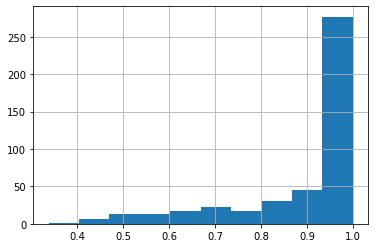

In [225]:
ensemble_result_metrics_drop_null[ensemble_result_metrics_drop_null['correct_effnet'] == True]['conf_score_effnet'].hist()

print(ensemble_result_metrics_drop_null[ensemble_result_metrics_drop_null['correct_effnet'] == True]['conf_score_effnet'].mean()
)


count    621.000000
mean       0.764749
std        0.199679
min        0.224108
25%        0.596031
50%        0.821104
75%        0.947300
max        0.999833
Name: conf_score_effnet, dtype: float64

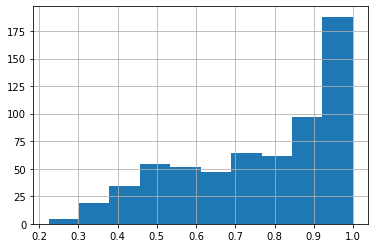

In [227]:

ensemble_result_metrics_drop_null[ensemble_result_metrics_drop_null['correct_effnet'] == False]['conf_score_effnet'].hist()

ensemble_result_metrics_drop_null[ensemble_result_metrics_drop_null['correct_effnet'] == False]['conf_score_effnet'].describe()



Yolo conf score analysis

In [222]:
ensemble_result_metrics_drop_null[ensemble_result_metrics_drop_null['correct_yolo'] == True]['conf_score_effnet'].describe()



count    622.000000
mean       0.843162
std        0.186957
min        0.224108
25%        0.733969
50%        0.930865
75%        0.993237
max        0.999978
Name: conf_score_effnet, dtype: float64

In [223]:
ensemble_result_metrics_drop_null[ensemble_result_metrics_drop_null['correct_yolo'] == False]['conf_score_effnet'].describe()



count    441.000000
mean       0.787233
std        0.193321
min        0.272060
25%        0.634220
50%        0.851447
75%        0.956632
max        0.999861
Name: conf_score_effnet, dtype: float64

In [228]:
ensemble_result_metrics_drop_null

,event_id,true_class,true_count,true_class_name,pred_class_effnet,conf_score_effnet,pred_class_name_effnet,pred_class_yolo,conf_score_yolo,pred_count_yolo,pred_class_name_yolo,correct_effnet,correct_yolo
0,SSWI000000004032002,"Fox, Gray",1,foxgray_foxred,5,0.994076,foxgray_foxred,5,0.869564,2,foxgray_foxred,True,True
1,SSWI000000004068822,"Fox, Gray",1,foxgray_foxred,5,0.852101,foxgray_foxred,7,0.885043,3,raccoon,True,False
2,SSWI000000004248668,Raccoon,1,raccoon,1,0.645938,cottontail_snowshoehare,7,0.584339,2,raccoon,False,True
3,SSWI000000004277676,"Fox, Gray",1,foxgray_foxred,1,0.813361,cottontail_snowshoehare,9,0.691431,4,wolf,False,False
4,SSWI000000004277809,"Fox, Gray",1,foxgray_foxred,5,0.598009,foxgray_foxred,2,0.476647,1,coyote,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,SSWI000000023457314,Coyote,1,coyote,5,0.909820,foxgray_foxred,5,0.741571,1,foxgray_foxred,False,False
1127,SSWI000000023457319,Coyote,1,coyote,5,0.224108,foxgray_foxred,2,0.834715,2,coyote,False,True
1128,SSWI000000023494506,"Fox, Gray",1,foxgray_foxred,5,0.848239,foxgray_foxred,5,0.850179,1,foxgray_foxred,True,True
1129,SSWI000000023514111,"Fox, Red",1,foxgray_foxred,5,0.785266,foxgray_foxred,5,0.906701,2,foxgray_foxred,True,True


In [234]:
y_true = ensemble_result_metrics_drop_null['true_class_name']


for yolo_multiplier in  np.linspace(0,.5,20):
    print(yolo_multiplier)

    def ensemble_logic(ensemble_row, yolo_multiplier):
        conf_score_effnet = ensemble_row['conf_score_effnet']
        conf_score_yolo = ensemble_row['conf_score_yolo'] 

        if conf_score_effnet > conf_score_yolo + (conf_score_yolo * yolo_multiplier):
            pred_class_name_ensemble = ensemble_row['pred_class_name_effnet']

        else:
            pred_class_name_ensemble = ensemble_row['pred_class_name_yolo']

        return pred_class_name_ensemble

    ensemble_result_metrics_drop_null['pred_class_name_ensemble'] = ensemble_result_metrics_drop_null.apply(lambda x: ensemble_logic(x, yolo_multiplier), axis =1)


    y_pred = ensemble_result_metrics_drop_null['pred_class_name_ensemble']
    label_list = np.unique(y_true)

    target_names = label_list
    print(classification_report(y_true, y_pred, target_names=target_names))


0.0
                         precision    recall  f1-score   support

                   bear       0.74      0.85      0.79       128
cottontail_snowshoehare       0.65      0.37      0.47       107
                 coyote       0.43      0.22      0.29       131
                   deer       0.78      0.27      0.41       172
                    elk       0.87      0.41      0.55       116
         foxgray_foxred       0.39      0.45      0.42        67
                opossum       0.70      0.40      0.51        47
                raccoon       0.74      0.52      0.61       107
                 turkey       0.54      0.73      0.62        62
                   wolf       0.28      0.90      0.43       126

               accuracy                           0.50      1063
              macro avg       0.61      0.51      0.51      1063
           weighted avg       0.62      0.50      0.50      1063

0.02631578947368421
                         precision    recall  f1-score   suppor

<ipython-input-234-97c00b39c717>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ensemble_result_metrics_drop_null['pred_class_name_ensemble'] = ensemble_result_metrics_drop_null.apply(lambda x: ensemble_logic(x, yolo_multiplier), axis =1)
<ipython-input-234-97c00b39c717>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ensemble_result_metrics_drop_null['pred_class_name_ensemble'] = ensemble_result_metrics_drop_null.apply(lambda x: ensemble_logic(x, yolo_multiplier), axis =1)
<ipython-input-234-97c00b39c

                         precision    recall  f1-score   support

                   bear       0.71      0.91      0.79       128
cottontail_snowshoehare       0.77      0.52      0.62       107
                 coyote       0.43      0.27      0.33       131
                   deer       0.81      0.32      0.46       172
                    elk       0.87      0.41      0.56       116
         foxgray_foxred       0.42      0.49      0.45        67
                opossum       0.71      0.43      0.53        47
                raccoon       0.74      0.63      0.68       107
                 turkey       0.59      0.79      0.68        62
                   wolf       0.33      0.87      0.47       126

               accuracy                           0.56      1063
              macro avg       0.64      0.56      0.56      1063
           weighted avg       0.65      0.56      0.55      1063

0.21052631578947367
                         precision    recall  f1-score   support

 

<ipython-input-234-97c00b39c717>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ensemble_result_metrics_drop_null['pred_class_name_ensemble'] = ensemble_result_metrics_drop_null.apply(lambda x: ensemble_logic(x, yolo_multiplier), axis =1)
<ipython-input-234-97c00b39c717>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ensemble_result_metrics_drop_null['pred_class_name_ensemble'] = ensemble_result_metrics_drop_null.apply(lambda x: ensemble_logic(x, yolo_multiplier), axis =1)
<ipython-input-234-97c00b39c